In [10]:
import pandas as pd
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import requests
import plotly.express as px
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import networkx as nx

pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', lambda x: f'%.{2}f' % x)
pd.set_option('display.max_colwidth', None)

In [11]:
df = pd.read_csv('8Jul2020-14Jul2020.csv')
df['Date'] = pd.to_datetime(df['Start Date'], dayfirst=True)
df.sort_values(by='Date', inplace=True)
df['Date'] = df['Date'].dt.date
df.head()

Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0   99188805       780    13656  08/07/2020 00:13            476   
1   99188806       180     4393  08/07/2020 00:03            531   
2   99188809       960     8973  08/07/2020 00:17            508   
3   99188810       960     7141  08/07/2020 00:17            508   
4   99188807       600    15085  08/07/2020 00:11            201   

                  EndStation Name        Start Date  StartStation Id  \
0  Stebondale Street, Cubitt Town  08/07/2020 00:00              532   
1     Twig Folly Bridge, Mile End  08/07/2020 00:00              517   
2    Fournier Street, Whitechapel  08/07/2020 00:01              779   
3    Fournier Street, Whitechapel  08/07/2020 00:01              779   
4       Dorset Square, Marylebone  08/07/2020 00:01              797   

               StartStation Name  EndStation lat  EndStation long  \
0    Jubilee Plaza, Canary Wharf           51.49            -0.01   
1            Ford Road, Old Ford           51.53            -0.04   
2           Houndsditch, Aldgate           51.52            -0.07   
3           Houndsditch, Aldgate           51.52            -0.07   
4  Ossulston Street, Somers Town           51.52            -0.16   

   EndStation nbBikes  EndStation nbStandardBikes  EndStation nbEBikes  \
0                  26                          24                    2   
1                   6                           6                    0   
2                   8                           8                    0   
3                   8                           8                    0   
4                  15                          15                    0   

   EndStation nbEmptyDocks  EndStation nbDocks  StartStation lat  \
0                        3                  29             51.50   
1                       15                  21             51.53   
2                       10                  18             51.51   
3                       10                  18             51.51   
4                        1                  16             51.53   

   StartStation long  StartStation nbBikes  StartStation nbStandardBikes  \
0              -0.02                    46                            45   
1              -0.03                     2                             2   
2              -0.08                     3                             3   
3              -0.08                     3                             3   
4              -0.13                    28                            27   

   StartStation nbEBikes  StartStation nbEmptyDocks  StartStation nbDocks  \
0                      1                         17                    63   
1                      0                         16                    18   
2                      0                         25                    28   
3                      0                         25                    28   
4                      1                          2                    30   

         Date  
0  2020-07-08  
1  2020-07-08  
2  2020-07-08  
3  2020-07-08  
4  2020-07-08

In [13]:
temp = df.groupby(['Date', 'StartStation Name', 'EndStation Name', 'StartStation lat', 'StartStation long',
                  'EndStation lat', 'EndStation long'])['Duration'].agg(['mean'])
#sorted(temp['EndStation Name'].unique()) == sorted(temp['StartStation Name'].unique())  #  verify no duplicate stations and that start and end stations are same
temp.reset_index(drop=False, inplace=True)
temp.head()

Date                  StartStation Name  \
0  2020-07-08  Abbey Orchard Street, Westminster   
1  2020-07-08  Abbey Orchard Street, Westminster   
2  2020-07-08  Abbey Orchard Street, Westminster   
3  2020-07-08  Abbey Orchard Street, Westminster   
4  2020-07-08  Abbey Orchard Street, Westminster   

                     EndStation Name  StartStation lat  StartStation long  \
0  Abbey Orchard Street, Westminster             51.50              -0.13   
1        Aldersgate Street, Barbican             51.50              -0.13   
2        Beaumont Street, Marylebone             51.50              -0.13   
3     Belgrove Street , King's Cross             51.50              -0.13   
4          Bricklayers Arms, Borough             51.50              -0.13   

   EndStation lat  EndStation long    mean  
0           51.50            -0.13 1720.00  
1           51.52            -0.10 1140.00  
2           51.52            -0.15 1020.00  
3           51.53            -0.12 1110.00  
4           51.50            -0.09 1140.00

In [37]:
N = 200

temp3 = temp['StartStation Name'].values[:N]
temp4 = temp[['StartStation lat', 'StartStation long']].apply(tuple, axis=1).values[:N]

temp5 = temp['EndStation Name'].values[:N]
temp6 = temp[['EndStation lat', 'EndStation long']].apply(tuple, axis=1).values[:N]

pos1 = {A: B for A, B in zip(temp3, temp4)}
pos2 = {A: B for A, B in zip(temp5, temp6)}
pos = {**pos1, **pos2}
pos

{'Abbey Orchard Street, Westminster': (51.49812559, -0.132102166),
 'Abbotsbury Road, Holland Park': (51.501391, -0.205991),
 "Aberdeen Place, St. John's Wood": (51.524826, -0.176268),
 'Aberfeldy Street, Poplar': (51.513548, -0.005659),
 'Abingdon Green, Westminster': (51.49764, -0.12597218),
 'Abingdon Villas, Kensington': (51.4973875, -0.197245586),
 'Abyssinia Close, Clapham Junction': (51.460333, -0.167029),
 'Ackroyd Drive, Bow': (51.520398, -0.026768),
 'Ada Street, Hackney Central': (51.53571683, -0.060291813),
 'Addison Road, Holland Park': (51.504199, -0.210941),
 'Aintree Street, Fulham': (51.48102131, -0.209973497),
 "Albany Street, The Regent's Park": (51.528302, -0.144466),
 'Albert Bridge Road, Battersea Park': (51.47439218, -0.163347594),
 'Albert Embankment, Vauxhall': (51.49043573, -0.122806861),
 'Albert Gardens, Stepney': (51.51328, -0.047784),
 'Albert Gate, Hyde Park': (51.50295379, -0.158456089),
 'Albert Square, Stockwell': (51.47659006, -0.118256789),
 'Alderne

In [38]:
temp3 = temp['StartStation Name'].values
temp4 = temp[['StartStation lat', 'StartStation long']].apply(tuple, axis=1).values

pos = {A: B for A, B in zip(temp3, temp4)}

In [39]:
# N = 200

X = np.array(temp[['StartStation Name', 'EndStation Name']])[:N]
y = np.array(temp['mean'])[:N]

temp1 = temp[['StartStation Name', 'EndStation Name']].apply(tuple, axis=1).values[:N]
temp2 = temp['mean'].values[:N]

edge_labels = {A: B for A, B in zip(temp1, temp2)}
# edge_labels

In [40]:
pos

{'Abbey Orchard Street, Westminster': (51.49812559, -0.132102166),
 'Abbotsbury Road, Holland Park': (51.501391, -0.205991),
 "Aberdeen Place, St. John's Wood": (51.524826, -0.176268),
 'Aberfeldy Street, Poplar': (51.513548, -0.005659),
 'Abingdon Green, Westminster': (51.49764, -0.12597218),
 'Abingdon Villas, Kensington': (51.4973875, -0.197245586),
 'Abyssinia Close, Clapham Junction': (51.460333, -0.167029),
 'Ackroyd Drive, Bow': (51.520398, -0.026768),
 'Ada Street, Hackney Central': (51.53571683, -0.060291813),
 'Addison Road, Holland Park': (51.504199, -0.210941),
 'Aintree Street, Fulham': (51.48102131, -0.209973497),
 "Albany Street, The Regent's Park": (51.528302, -0.144466),
 'Albert Bridge Road, Battersea Park': (51.47439218, -0.163347594),
 'Albert Embankment, Vauxhall': (51.49043573, -0.122806861),
 'Albert Gardens, Stepney': (51.51328, -0.047784),
 'Albert Gate, Hyde Park': (51.50295379, -0.158456089),
 'Albert Square, Stockwell': (51.47659006, -0.118256789),
 'Alderne

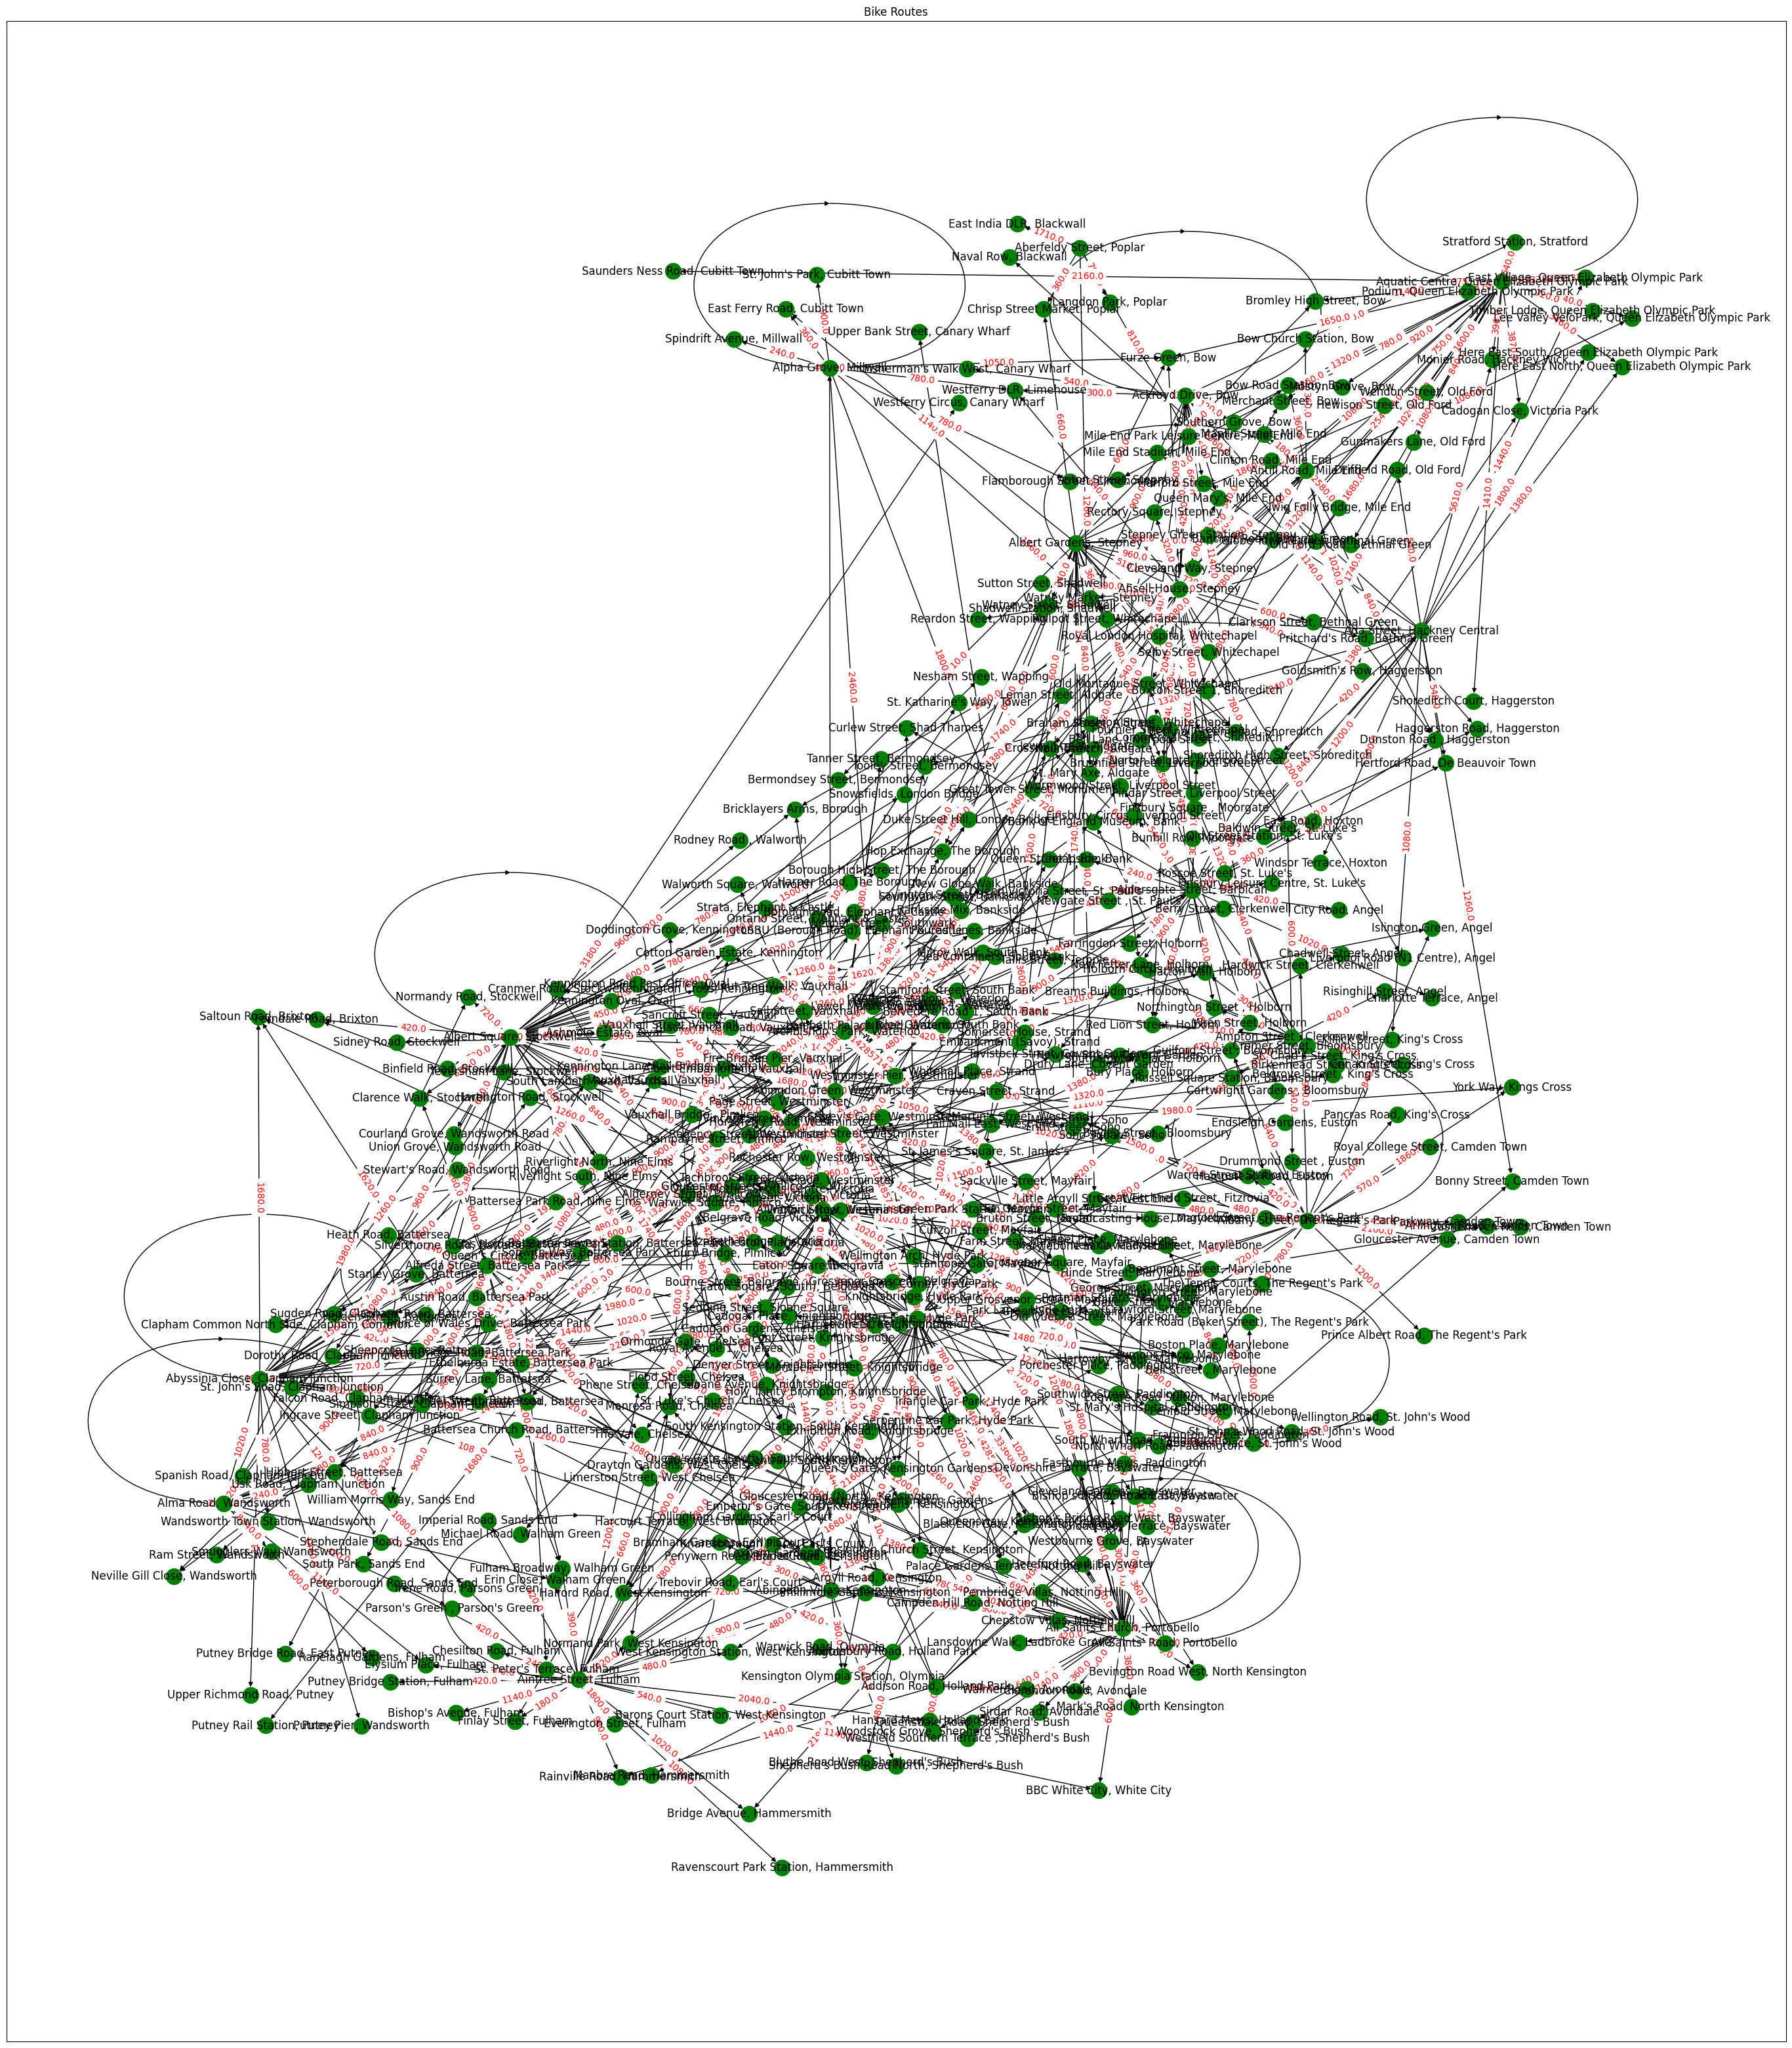

In [41]:
G = nx.DiGraph()
G.add_edges_from(X)
plt.figure(figsize =(35, 40))
nx.draw_networkx(G, pos = pos, node_color ='green')
nx.draw_networkx_edge_labels(G, pos = pos,
                             edge_labels=edge_labels,
                             font_color='red')


plt.title("Bike Routes")
plt.show()